# Sustainability Countries in Our World
สำหรับโปรเจกต์นี้จะนำข้อมูลด้านต่าง ๆ ของโลกทั้งหมด 5 ประเด็น โดยมี
1. Economic; ข้อมูลด้านเศรษฐกิจ
2. Environment; ข้อมูลด้านสิ่งแวดล้อม
3. Health; ข้อมูลด้านสุขภาพ
4. Human; ข้อมูลด้านสิทธิมนุษยชน
5. Politic; ข้อมูลด้านการเมืองการปกครอง<br><br>

โดยทั้ง 5 ด้านนี้ จะนำมาทำการวิเคราะห์หาว่า ประเทศในโลกทั้งหมดมีการเกาะกลุ่มกันแต่ละด้านอย่างไรบ้าง (Cluster Analysis) อีกทั้งจะนำประเด็นทั้ง 5 มาหาค่าดัชนีชี้วัดรวมที่มีชื่อว่า Sustanability Index โดยเกิดจากการนำค่า Index ของทั้ง 5 ด้านมาหาค่าเฉลี่ย เพื่อดูว่าแต่ละประเทศของโลกเรานั้น มีความยั่งยืนในแต่ละด้านและทั้ง 5 ด้านอย่างไรบ้าง

### Import Package and check dataset
 เนื่องจากข้อมูลมากจากหลายแหล่งรวมกัน (World Bank, OurWorldinData, etc.) จึงต้องมีการตรวจสอบข้อมูลเพื่อดูว่ามีข้อมูลขาดหายไปมากน้อยแค่ไหน

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import missingno as msno
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import gmean

In [11]:
# Load Dataset
worldData = pd.read_csv('datasets/raw_world_source_ana.csv', na_values=["-"], encoding='cp1252')
worldData.iloc[:,3:7].head()

,Ease of doing business score (0 = lowest performance to 100 = best performance),Economic Growth,"Employment to population ratio, 15+, total (%) (modeled ILO estimate)",GDP (current US$)
0,44.06497,-2.35,35.893002,1.478686e+10
1,67.74847,8.54,51.609001,1.825579e+10
2,48.59758,3.85,35.113998,1.630000e+11
3,41.28838,0.70,69.936996,6.740429e+10
4,58.96151,10.26,53.814999,4.870000e+11


In [12]:
# Check dimensions of it
worldData.shape

(174, 89)

ข้อมูลของเรามีทั้งหมด 89 features และ 174 records ซึ่งดูรวม ๆ แล้วปริมาณด้านที่เยอะคือด้านตัวแปรรเป็นหลัก

Country                                                                            0
ISO Country code                                                                   0
Continent                                                                          0
Ease of doing business score (0 = lowest performance to 100 = best performance)    4
Economic Growth                                                                    7
                                                                                  ..
Political Rights Score                                                             0
Political Stability & Absence Of Violence                                          1
Regulatory Quality                                                                 1
Rule Of Law                                                                        1
UHC service coverage index                                                         2
Length: 89, dtype: int64

<AxesSubplot:>

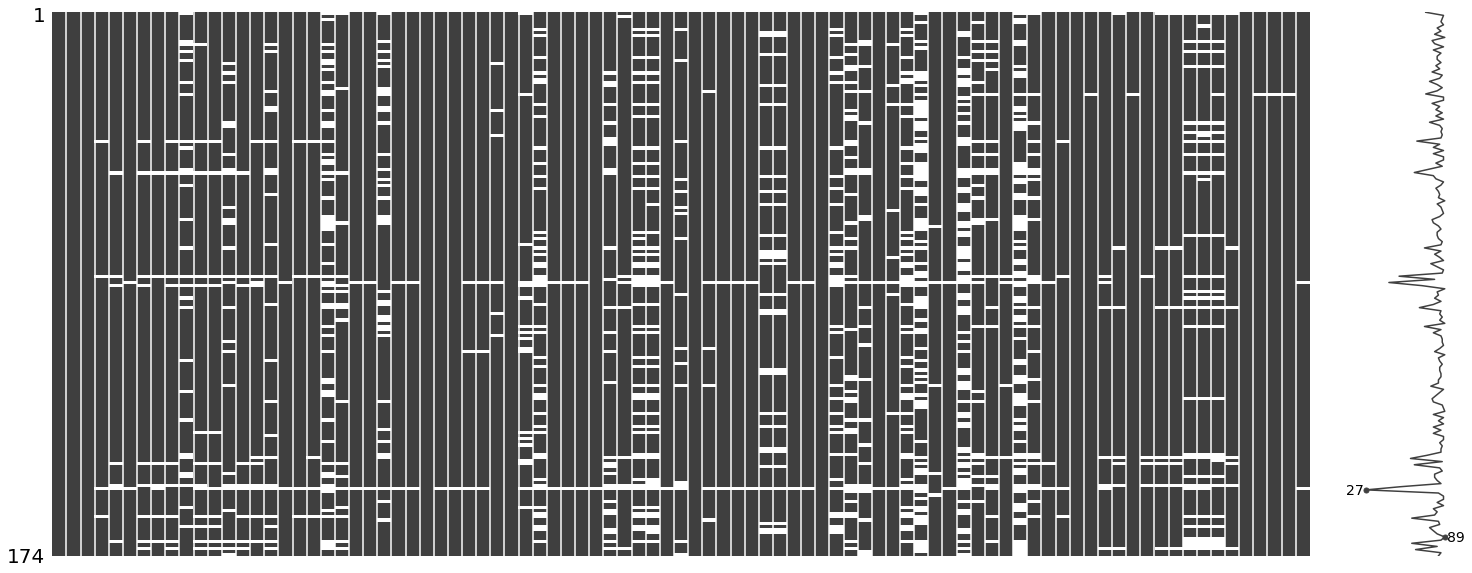

In [13]:
# Check NA data
display(worldData.isna().sum())

# Check with missing matrix plot
msno.matrix(worldData)

### Imputation

จากรูปจะเห็นว่ามี features ประมาณ 1 ใน 3 ที่มีการขาดหายของข้อมูลในปริมาณมาก ซึ่งในการทำ Clustering การขาดหายของข้อมูลนั้นสำคัญมาก เพราะอาจจะทำให้ไม่สามารถที่จะประมวนผลลัพธ์ออกมาได้<br><br>

ดังนั้น จึงต้องมีการทำ Imputation หรือ การเติมเต็มข้อมูลที่หายไป โดยในที่นี้จะใช้วิธีการ Multiple Imputations by Chained Equation (MICE) โดยจะอิงจาก features ที่เหลืออีก 2 ใน 3 เพื่อให้ทราบแนวโน้มของข้อมูลและเติมข้อมูลลงไป

In [14]:
def into_the_unknown(DataFrame, scaler, Imputer):
    # Imputation with copied dataframe imputing with MICE: worldDataMICE
    imputedDataFrame = DataFrame.iloc[:,3:].copy(deep = True)

    # Scaling data
    scalingImputedDataFrame = scaler.fit_transform(imputedDataFrame)

    # Imputing data to copied dataframe
    imputedDataFrame.iloc[:,:] = Imputer.fit_transform(scalingImputedDataFrame)

    # Invere transform data
    imputedDataFrame = scaler.inverse_transform(imputedDataFrame)

    # Convert data to DataFrame
    imputedDataFrame = pd.DataFrame(imputedDataFrame)

    return imputedDataFrame

In [15]:
worldDataMICE = into_the_unknown(worldData, MinMaxScaler(), IterativeImputer(min_value=0 ,max_value=1))

C:\Program Files\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [16]:
worldDataMICE.to_csv('datasets/world_source_ana_MICEimputed.csv', encoding='UTF-8')

### TSNE model และ การหาค่า Index

หลังจากผ่านกระบวนการ Imputation ไปเรียบร้อยแล้ว ขั้นตอนต่อไปคือการนำข้อมูลหาค่า Index และเข้า TSNE model ดังนี้
1. หาค่า Index แยกประเด็นแต่ละด้าน
2. จัด Class แต่ละประเทศ โดยให้ประเทศที่มีค่า Index สูงกว่าค่าเฉลี่ยของ Index เป็นประเทศ High Class ส่วนอีกกร๊ให้เป็น Low Class 
3. นำข้อมูล(ไม่รวม Index และ Class) เข้าสู่ TSNE model ที่มีการ Tuning parameters แล้ว

นำข้อมูลเข้า พร้อมทั้งตรวจสอบว่าข้อมูลครบหรือไม่

In [38]:
# Load world_source_ana_MICEimputed and Factors: df, factors
df = pd.read_csv('data_for_dev/without_tsne_and_indexed/world_data_imputed.csv', encoding='cp1252')
factors = pd.read_csv('data_for_dev/without_tsne_and_indexed/factors.csv')
# Assign features to factors
Factors = ['Economic', 'Environment', 'Health', 'Human', 'Politic']

display(df[list(factors[(factors['Factor'] == Factors[3]) & (factors['Direction'] == 'D')]['Columns'])].head())
factors['Factor'].unique()

,% of seats held by women in national parliaments,Access to electricity (% of population),Education as % of GDP,Happy Planet Index,Human capital index (HCI) (scale 0-1),Human Development Index,"School enrollment, secondary (% gross)",Sustainable Economic Development Assessment (SEDA),Women Business and the Law Index Score (scale 1-100)
0,27.0,97.699997,3.21,29.400000,0.400284,0.478,54.825329,26.300584,38.125
1,36.0,100.000000,3.10,51.000000,0.634251,0.796,94.280327,53.100000,91.250
2,8.0,99.804131,6.10,46.500000,0.534556,0.745,88.763870,45.800000,57.500
3,30.0,46.890610,2.42,42.208466,0.362405,0.586,52.524211,28.400000,79.375
4,45.0,100.000000,4.72,50.000000,0.602145,0.842,110.128220,57.300000,79.375


array(['Economic', 'Environment', 'Health', 'Human', 'Politic'],
      dtype=object)

ลองตรวจสอบดูว่าแต่ละประเด็นนั้น นำมากี่ Features

In [39]:
dict(zip(Factors, [len(factors[factors['Factor'] == i]['Columns']) for i in Factors]))

{'Economic': 19, 'Environment': 12, 'Health': 27, 'Human': 11, 'Politic': 17}

ก่อนจะนำข้อมูลเข้าสู่กระบวนการหาค่า Index หรือ TSNE จะต้องทำการ Normalization ก่อน โดยมีข้อพึงระวัง 2 ข้อ
1. ทิศทางข้อมูลก่อน Normalization; ไม่ใช่ข้อมูลทุก features ที่ยิ่งค่ามากแล้วจะเป็นไปในทางที่ดีหรือทางที่คาดหวัง อาทิ จำนวนการตายของทารกแรกเกิด จำนวนผู้ติดเชื้อ HIV จำนวนการปล่อย CO2 เป็นต้น
2. หลัง Normalization ต้องไม่เป็น 0; แม้ว่าจะใช้หลัการ Min - Max ซึ่งทำให้ค่าอยู่ในช่วง 0 - 1 แต่หากจะนำไปหาค่า Geometric mean ซึ่งเป็นผลคูณของทุกข้อมูล จะทำให้ Index เกิดค่า 0 ซึ่งอาจไม่เป็นสามารถหาความหมายเพิ่มเติมได้ จึงต้องปรับค่าให้เหมาะสมโดยไม่เสียนัยยะ

In [19]:
def normData(df, directedCols, undirectedCols):
    # Function for directed features
    def dNorm(data):
        # Adjusted value
        a = 0.0000001
        Min = data.min(axis = 0, skipna = True) - a
        Max = data.max(axis = 0, skipna = True)
        dNormDf = (data - Min)/(Max - Min)
        return dNormDf
    # Function for indirected features
    def udNorm(data):
        # Adjusted value
        a = 0.0000001
        Min = data.min(axis = 0, skipna = True) 
        Max = data.max(axis = 0, skipna = True) + a
        udNormDf = 1- (data - Min)/(Max - Min)
        return udNormDf
    
    # Calculating normalization
    dNorm_ = dNorm(df[directedCols])
    udNorm_ = udNorm(df[undirectedCols])

    # Send output as DataFame
    dataNorm = pd.concat([dNorm_, udNorm_], axis = 1)
    return dataNorm

สร้างฟังก์ชันหาค่า Index รวมแต่ละด้าน พร้อมทั้งจัด Class

In [20]:
def index_class(df, Factor):
    # TSNE for visualization each factor
    data = normData(df, list(factors[(factors['Factor'] == Factor) & (factors['Direction'] == 'D')]['Columns']),
    list(factors[(factors['Factor'] == Factor) & (factors['Direction'] == 'I')]['Columns']))

    # If any datapoint is 0, replace with 0.0000001
    data = data.replace(0,0.0000001)

    # Find index by geometric mean
    data[Factor+'Index'] = data.apply(gmean,axis = 1)

    # Find average for creating data class
    Mean = data[Factor+'Index'].mean()
    data.loc[data[Factor+'Index'] >= Mean,Factor+'Class'] = 'High'
    data.loc[data[Factor+'Index'] < Mean, Factor+'Class'] = 'Low'
    
    return data

In [40]:
dataFrame = [index_class(df, Factor) for Factor in Factors]

In [41]:
# Get name of country and continent for colour in data visualization
country = df['Country'].values
continent = df['Continent']

In [42]:
# Run the model for all data
Tsne_name = ['tsne_eco', 'tsne_env', 'tsne_hel', 'tsne_hum', 'tsne_pol']
Tsne = []
X = []
Y = []

for index in range(len(Factors)-1):
    values = dataFrame[index].iloc[:,:-2].values

    model = TSNE(learning_rate = 100, perplexity=50)
    tsne_features = model.fit_transform(values)

    xs = tsne_features[:,0]
    ys = tsne_features[:,1]

    Tsne.append(tsne_features)
    X.append(xs)
    Y.append(ys)

หลังจากนำข้อมูลเข้า TSNE model แล้ว นำข้อมูลทุกประเด็นมารวมกันเพื่อนำข้อมูลรวมทั้งหมด หา Sustainability index และ Cluster ทุกประเด็น

In [43]:
dfCombine = pd.concat([dataFrame[0]['EconomicIndex'], dataFrame[1]['EnvironmentIndex'], 
dataFrame[2]['HealthIndex'], dataFrame[3]['HumanIndex'], dataFrame[4]['PoliticIndex']], axis = 1)

In [44]:
dfALL = normData(df, list(factors[factors['Direction'] == 'D']['Columns']),
list(factors[factors['Direction'] == 'I']['Columns']))

dfALL['AllIndex'] = dfCombine.mean(axis=1)

Mean = dfALL['AllIndex'].mean()
dfALL.loc[dfALL['AllIndex'] >= Mean,'AllClass'] = 'High'
dfALL.loc[dfALL['AllIndex'] < Mean, 'AllClass'] = 'Low'

dataFrame.append(dfALL)
Factors.append('All')

In [62]:
values = dfALL.iloc[:,:-2].values

model = TSNE(learning_rate = 100, perplexity=50)
tsne_All = model.fit_transform(values)

xs = tsne_All[:,0]
ys = tsne_All[:,1]

Tsne.append(tsne_All)
X.append(xs)
Y.append(ys)

ตรวจสอบ Parameters ที่ใช้ในตัวแบบนี้

In [ ]:
display((model.learning_rate_, model.perplexity, model.method, model.n_iter_, model.n_features_in_))

(100, 50, 'barnes_hut', 999, 86)

### Data visualization

ลอง Plot ข้อมูลเพื่อตรวจสอบ Cluster

In [65]:
# Plot with plotly
# {0: Economic, 1: Environment; 2: Health, 3: Human, 4: Politic, 5: All}
i = 5
fig = px.scatter(x = X[i], y = Y[i], color = dataFrame[i].iloc[:,-1],  hover_name=country, 
                template = 'seaborn', width = 800, height = 500
                )

fig.show()

In [66]:
fig = px.strip(y = dataFrame[i].iloc[:,-2], color = dataFrame[i].iloc[:,-1],  hover_name=country, 
                template = 'seaborn', width = 800, height = 500
                )

fig.show()

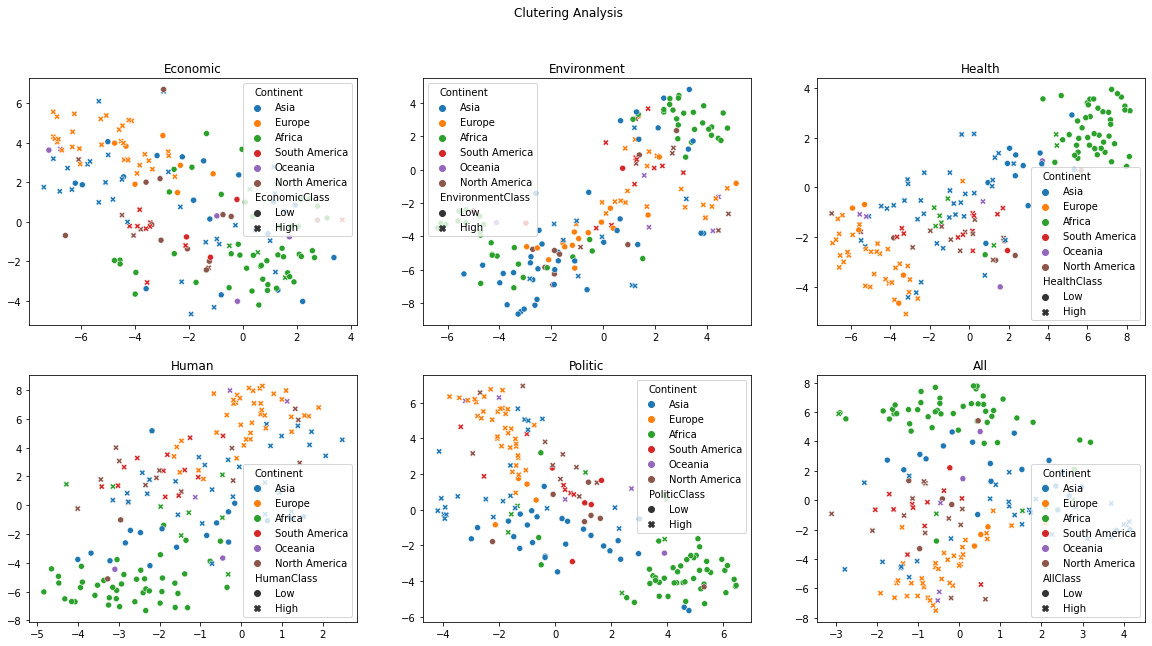

In [67]:
fig, axes = plt.subplots(2,3, figsize = (20,10))
fig.suptitle('Clutering Analysis')

for row in range(2):
    for col in range(3):
        if(row != 1):
            axes[row,col].set_title(Factors[col+row])
            sns.scatterplot(ax = axes[row,col], x = X[col+row], y = Y[col+row], style = dataFrame[col+row].iloc[:,-1], hue = continent)
        else:
            axes[row,col].set_title(Factors[col+row+2])
            sns.scatterplot(ax = axes[row,col], x = X[col+row+2], y = Y[col+row+2], style = dataFrame[col+row+2].iloc[:,-1], hue = continent)
plt.savefig("plot/cluster.svg")

### Export data and etc.

In [ ]:
for n, m in zip(Tsne_name, Tsne):
    pd.DataFrame(m).to_csv('TSNE/'+n+'.csv', index = False)

In [ ]:
nameIndex = ['datasets/indexes/indexECO.csv', 'datasets/indexes/indexENV.csv', 'datasets/indexes/indexHEL.csv', 'datasets/indexes/indexHUM.csv', 'datasets/indexes/indexPOL.csv', 'datasets/indexes/indexALL.csv']

for d, n in zip(dataFrame, nameIndex):
    pd.DataFrame(d.iloc[:,-2:]).to_csv(n, index = False)

In [ ]:
tsne_and_index = [pd.concat([pd.DataFrame(Tsne[i]),dataFrame[i].iloc[:,-2:]], axis = 1) for i in range(6)]

In [ ]:
tsne_and_indexes = pd.concat(tsne_and_index, axis = 1)

In [ ]:
tsne_and_indexes.to_csv('data_for_dev/tsne_and_indexes.csv', index = False)

In [ ]:
# Combine dataframe from split factor df
DF = [df[list(factors[factors['Factor'] == Factors[i]]['Columns'])] for i in range(len(Factors))]

worldFactor = pd.concat(DF, axis = 1)

In [ ]:
worldFactor.to_csv('data_for_dev/world_data.csv', index = False)